<a href="https://colab.research.google.com/github/TonyKimisintheHouse/Self-Study-ML-Fundamentals-and-DL/blob/master/notes/PRML_Chapter_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Pattern Recognition and Machine Learning Chapter 1

*All codes based on [ctgk](https://github.com/ctgk)'s work. Thank you so much!*

In [0]:
import numpy as np
import matplotlib.pyplot as plt

np.random.seed(1234)

In [0]:
def create_toy_data(func, sample_size, std):
  x = np.linspace(0, 1, sample_size)
  t = func(x) + np.random.normal(scale = std, size = x.shape)
  return x, t

def func(x):
  return np.sin(2 * np.pi * x)

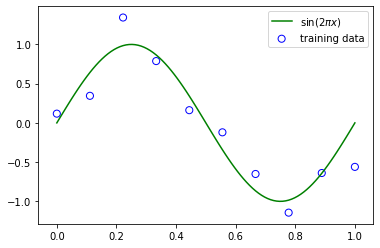

In [7]:
x_train, y_train = create_toy_data(func, 10, 0.25)
x_test = np.linspace(0, 1, 100)
y_test = func(x_test)

plt.scatter(x_train, y_train, facecolor="none", edgecolor="b", s = 50, label = "training data")
plt.plot(x_test, y_test, c ="g", label="$\sin(2\pi x)$")
plt.legend()
plt.show()

## Capacity, Overfitting, and Underfitting 

In [0]:
import itertools
import functools

class PolynomialFeature(object):

  def __init__(self, degree = 2):
    """
    construct polynomial features

    Parameters
    ----------
    degree : int
      degree of polynomial
    """
    assert isinstance(degree, int)
    self.degree = degree

  def transform(self, x):
    """
    transforms input array with polynomial features

    Parameters
    ----------
    x : (sample_size, n) ndarray
        input array

    Returns
    -----
    output : (sample_size, 1 + nC1 + ... + nCd) ndarry
      polynomial features
    """
    if x.ndim == 1:
      x = x[:, None]
    x_t = x.transpose()
    features = [np.ones(len(x))]
    for degree in range(1, self.degree + 1):
      for items in itertools.combinations_with_replacement(x_t, degree):
        features.append(functools.reduce(lambda x, y: x * y, items))
    return np.asarray(features).transpose()

In [0]:
class LinearRegression(object):
  
  def fit(self, X:np.ndarray, t:np.ndarray):
    """
    Perform least square fitting

    Parameters
    ----------
    X : (N, D) np.ndarray
        training independent variables

    T : (N, ) np.ndarray
        training dependent variables
    """

    self.w = np.linalg.pinv(X) @ t 
    # note np.lialg.pinv finds the pseudo inverse 
    # note @ performs a typical matrix multiplication
    self.var = np.mean(np.square(X @ self.w - t))

  def predict(self, X:np.ndarray, return_std:bool=False):
    """
    Make prediction given input

    Parameters
    ----------
    X : (N, D) np.ndarray
        samples to predict their output
      
    return_std: bool, optional
        returns standard deviation of each prediction if True

    y : (N, ) np.ndarray
              prediction of each sample

    y_std: (N, ) np.ndarray
              standard deviation of each prediction
    """

    y = X @ self.w
    if return_std:
      y_std = np.sqrt(self.var) + np.zeros_like(y)
      return y, y_std

    return y

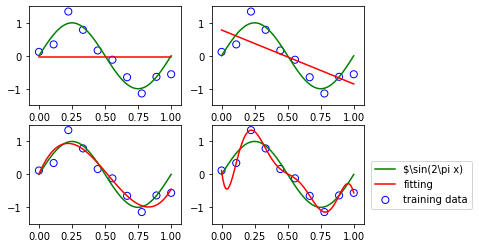

In [16]:
for i, degree in enumerate([0, 1, 3, 9]):
  plt.subplot(2, 2, i + 1)
  feature = PolynomialFeature(degree)
  X_train = feature.transform(x_train)
  X_test = feature.transform(x_test)

  model = LinearRegression()
  model.fit(X_train, y_train)
  
  y = model.predict(X_test)

  plt.scatter(x_train, y_train, facecolor="none", edgecolor="b", s=50, label="training data")
  plt.plot(x_test, y_test, c="g", label="$\sin(2\pi x)")
  plt.plot(x_test, y, c="r", label="fitting")
  plt.ylim(-1.5, 1.5)
  plt.annotate("M={}".format(degree), xy=(-0.15, 1))
plt.legend(bbox_to_anchor=(1.05, 0.64), loc=2, borderaxespad=0.)
plt.show()

Text(0, 0.5, 'RMSE')

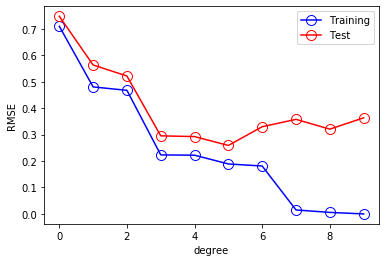

In [17]:
def rmse(a, b):
    return np.sqrt(np.mean(np.square(a - b)))

training_errors = []
test_errors = []

for i in range(10):
    feature = PolynomialFeature(i)
    X_train = feature.transform(x_train)
    X_test = feature.transform(x_test)

    model = LinearRegression()
    model.fit(X_train, y_train)
    y = model.predict(X_test)
    training_errors.append(rmse(model.predict(X_train), y_train))
    test_errors.append(rmse(model.predict(X_test), y_test + np.random.normal(scale=0.25, size=len(y_test))))

plt.plot(training_errors, 'o-', mfc="none", mec="b", ms=10, c="b", label="Training")
plt.plot(test_errors, 'o-', mfc="none", mec="r", ms=10, c="r", label="Test")
plt.legend()
plt.xlabel("degree")
plt.ylabel("RMSE")

## Bayesian Curve Fitting

In [0]:
class BayesianRegression(object):
  """
  Bayesian regression model

  w ~ N(w|0, alpha^(-1)I)
  y = X @ w
  t ~ N(t| X @ w, beta^(-1))
  """

  def __init__(self, alpha:float = 1., beta:float = 1.):
    self.alpha = alpha
    self.beta = beta
    self.w_mean = None
    self.w_precision = None
  
  def _is_prior_defined(self) -> bool:
    return self.w_mean is not None and self.w_precision is not None

  def _get_prior(self, ndim:int) -> tuple:
    if self._is_prior_defined():
      return self.w_mean, self.w_precision

    else:
      return np.zeros(ndim), self.alpha * np.eye(ndim)

  def fit(self, X:np.ndarray, t:np.ndarray):
    """
    bayesian update of parametesr given training dataset

    Parameters
    ---------
    X : (N, n_features) np.ndarray

    t : (N, ) np.ndarray
    """

    mean_prior, precision_prior = self._get_prior(np.size(X, 1)) 
    
    """
    note: np.size(X, 1) returns the number of columns,
    which is the number of weights in this case
    """

    w_precision = precision_prior + self.beta * X.T @ X
    w_mean = np.linalg.solve(
        w_precision,
        precision_prior @ mean_prior + self.beta * X.T @ t
    )
    self.w_mean = w_mean
    self.w_precision = w_precision
    self.w_cov = np.linalg.inv(self.w_precision)

  def predict(self, X:np.ndarray, return_std:bool = False, sample_size:int = None):
    """
    return mean (and standard deviation) of predictive distribution

    Parameters
    ----------
    X : (N, n_features) np.ndarray
        independent variable
    return_std : bool, optional
        flag to return standard deviation (the default is False)
    sample_size : int, optional
        number of samples to draw from the predictive distribution
        (the default is None, no sampling from the distribution)
    Returns
    -------
    y : (N,) np.ndarray
        mean of the predictive distribution
    y_std : (N,) np.ndarray
        standard deviation of the predictive distribution
    y_sample : (N, sample_size) np.ndarray
        samples from the predictive distribution
    """

    if sample_size is not None:
        w_sample = np.random.multivariate_normal(
            self.w_mean, self.w_cov, size=sample_size
        )
        y_sample = X @ w_sample.T
        return y_sample
    y = X @ self.w_mean
    if return_std:
        y_var = 1 / self.beta + np.sum(X @ self.w_cov * X, axis=1)
        y_std = np.sqrt(y_var)
        return y, y_std
    return y

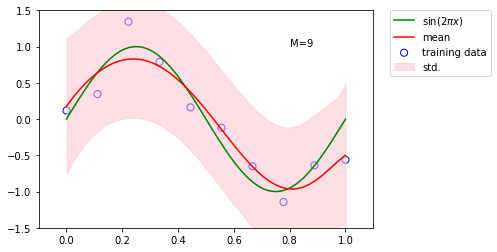

In [22]:
model = BayesianRegression(alpha=2e-3, beta=2)
model.fit(X_train, y_train)

y, y_err = model.predict(X_test, return_std=True)

plt.scatter(x_train, y_train, facecolor="none", edgecolor="b", s=50, label="training data")
plt.plot(x_test, y_test, c="g", label="$\sin(2\pi x)$")
plt.plot(x_test, y, c="r", label="mean")
plt.fill_between(x_test, y - y_err, y + y_err, color="pink", label="std.", alpha=0.5)

plt.xlim(-0.1, 1.1)
plt.ylim(-1.5, 1.5)
plt.annotate("M=9", xy=(0.8, 1))
plt.legend(bbox_to_anchor=(1.05, 1.), loc=2, borderaxespad=0.)
plt.show()
